In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

from tqdm import tqdm
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error, roc_auc_score
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from collections import Counter, defaultdict


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dacon-lg/train_problem_data.csv
/kaggle/input/dacon-lg/sample_submission.csv
/kaggle/input/dacon-lg/test_err_data.csv
/kaggle/input/dacon-lg/train_err_data.csv
/kaggle/input/dacon-lg/train_quality_data.csv
/kaggle/input/dacon-lg/test_quality_data.csv


In [2]:
%%time
train_err = pd.read_csv("/kaggle/input/dacon-lg/train_err_data.csv")
train_qual = pd.read_csv("/kaggle/input/dacon-lg/train_quality_data.csv")
train_prb = pd.read_csv("/kaggle/input/dacon-lg/train_problem_data.csv")

is_trainn = False
if is_trainn:
    train_err = train_err[:100000]

CPU times: user 17.4 s, sys: 1.13 s, total: 18.5 s
Wall time: 24.8 s


<string>:2: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
train_err['']

KeyError: ''

# Feature Engineering

In [4]:
imp_list = defaultdict(lambda x: 'error')
def preprcss(data, data_qual, is_train=True):
    # NA
    data['errcode'].fillna(1)
    
    # CNT dictionary
    tmp = data.groupby('user_id')['time'].count()
    cnt_dic = defaultdict(lambda :99999, zip(tmp.index, tmp))
    
    # fwver_changed dictionary
    tmp = data.groupby('user_id')['fwver'].nunique()
    tmp2=  tmp.apply(lambda x: 0 if x==1 else 1)
    fwver_dic = defaultdict(lambda :0, zip(tmp2.index, tmp2))
    
    tmp = data_qual.groupby('user_id')['fwver'].nunique()
    tmp2 = tmp.apply(lambda x: 1 if x>1 else 0)
    qualfwver_dic = defaultdict(lambda :0, zip(tmp2.index, tmp2))
    
    data['fw'] = data['fwver'].apply(lambda x:x[:5])
    tmp = data.groupby('user_id')['fw'].nunique()
    tmp2=  tmp.apply(lambda x: 0 if x==1 else 1)
    fw_dic = defaultdict(lambda :0, zip(tmp2.index, tmp2))  
    data.drop('fw', axis=1, inplace=True)
    
    def upgrade_chk(x):
        ans=0
        start=x[0]
        for value in x[1:]:
            if start < value:
                ans += 1
            start = value
        return ans

    def downgrade_chk(x):
        ans=0
        start=x[0]
        for value in x[1:]:
            if start > value:
                ans += 1
            start = value
        return ans

    data['fwver_num'] = data['fwver'].apply(lambda x: int(x.replace(".","")))
    tmp = data.groupby('user_id')['fwver_num'].unique()
    tmp2 = tmp.apply(upgrade_chk)
    up_dic = defaultdict(lambda :0, zip(tmp2.index, tmp2))
    tmp2 = tmp.apply(downgrade_chk)
    down_dic = defaultdict(lambda :0, zip(tmp2.index, tmp2))
    
    # model_changed dictionary
    tmp = data.groupby('user_id')['model_nm'].nunique()
    tmp2=  tmp.apply(lambda x: 0 if x==1 else 1)
    model_dic = defaultdict(lambda :0, zip(tmp2.index, tmp2))
    
    # errtype/errcode nunique dictionary
    tmp = data.groupby('user_id')['errcode'].nunique()
    tmp2=  tmp.apply(lambda x: 0 if x==1 else 1)
    ecode_dic = defaultdict(lambda :0, zip(tmp2.index, tmp2))
    
    tmp = data.groupby('user_id')['errtype'].nunique()
    tmp2=  tmp.apply(lambda x: 0 if x==1 else 1)
    etype_dic = defaultdict(lambda :0, zip(tmp2.index, tmp2))
    
    # qual_change
    tmp = data_qual.groupby('user_id')[['quality_'+str(i) for i in range(13)]].nunique()-1
    tmp2 = tmp.sum(axis=1)
    qual_dic = defaultdict(lambda :0, zip(tmp2.index, tmp2))
    
    # qual_absdiff
    dat = data_qual.copy()
    dat['time'] = pd.to_datetime(dat['time'], format="%Y%m%d%H%M%S")
    dat['key'] = dat['time'].astype(str) + dat['user_id'].astype(str) + dat['fwver']
    seq = []
    is_first = True
    for i, key in enumerate(dat['key']):
        if is_first:
            start = 0
            is_first=False
            seq.append(start)
        else:
            if key == prev_key:
                start += 1
            else:
                start = 0
            seq.append(start)
        prev_key = key
    dat['seq'] = seq
    dat['min'] = dat['seq'].apply(lambda x: pd.Timedelta(minutes=10*x))
    dat['time2'] = dat['time'] + dat['min']

    for col in ['quality_'+str(i) for i in range(13)]:
        dat[col+'_lag1'] = dat.groupby(['time', 'user_id', 'fwver'])[col].shift(1)

    for col in ['quality_'+str(i) for i in range(13)]:
        dat[col+'_absdiff'] = abs(dat[col].apply(lambda x:float(str(x).replace(",",""))) - dat[col+'_lag1'].apply(lambda x:float(str(x).replace(",",""))))

    qual_absdiff = dat.groupby('user_id',as_index=False)[['quality_'+str(i)+'_absdiff' for i in range(13)]].mean()
    
    # qual_nzero_cnt
    data_qual.fillna(0, inplace=True)
    dat = data_qual[['user_id']+['quality_'+str(i) for i in range(13)]]
    dat = pd.concat([dat[['user_id']], (dat[['quality_'+str(i) for i in range(13)]] !=0).astype(int)], axis=1)
    qual_nzero_cnt = dat.groupby('user_id', as_index=False)[['quality_'+str(i) for i in range(13)]].sum()
    
    # qual_0 qual_2 trend
    t1=data_qual.groupby(['user_id', 'fwver'])[['quality_0', 'quality_2']].nth(7) 
    t1.fillna(0, inplace=True)
    t2=data_qual.groupby(['user_id', 'fwver'])[['quality_0', 'quality_2']].nth(4) 
    t2.fillna(0, inplace=True)
    qualdiff_trend = (t1-t2).reset_index().rename(columns={'quality_0':"qual0_trend", 'quality_2':"qual2_trend"})
    qualdiff_trend.drop('fwver',axis=1,inplace=True)
    qualdiff_trend = qualdiff_trend.groupby('user_id')[['qual0_trend', 'qual2_trend']].mean()
    
    # n_qual * (mainhour, day)
    data_qual.fillna(0, inplace=True)
    data_qual['time'] = pd.to_datetime(data_qual['time'], format="%Y%m%d%H%M%S")
    data_qual['HH'] = data_qual['time'].dt.hour
    data_qual['MMDD'] = data_qual['time'].dt.month.astype(str) + data_qual['time'].dt.day.astype(str)
    data_qual['day'] = data_qual['MMDD'].apply(lambda x: 'Mon'  if x in ['112','119','1116','1123','1130'] else ('Sat' if x in['117','1114','1121','1128'] else ('Sun' if x in ['111','118','1115','1122','1129'] else 'etc')))
    data_qual['mainhour'] = data_qual['HH'].apply(lambda x: 1 if int(x)>=10 and int(x)<=23 else 0)
    tmp = (data_qual.groupby(['user_id' ,'day'])[list(map(lambda x: 'quality_'+ x, [str(i) for i in range(13)]))].nunique()-1).sum(axis=1).reset_index().rename(columns={0:'n_qualchange'})
#     tmp = tmp[tmp['day']!='etc']

    tmp2 = pd.pivot_table(tmp, 
                          values='n_qualchange',
                         index=['user_id'],
                         columns='day',
                         aggfunc=sum)
    day_nqual = tmp2.fillna(0).reset_index().rename(columns={'Mon':'Mon_nqual',
                                                               'Sat':'Sat_nqual',
                                                               'Sun':'Sun_nqual'})
    
    tmp = (data_qual.groupby(['user_id' ,'mainhour'])[list(map(lambda x: 'quality_'+ x, [str(i) for i in range(13)]))].nunique()-1).sum(axis=1).reset_index().rename(columns={0:'n_qualchange'})
#     tmp = tmp[tmp['mainhour']!=0]

    tmp2 = pd.pivot_table(tmp, 
                          values='n_qualchange',
                         index=['user_id'],
                         columns='mainhour',
                         aggfunc=sum)
    mainhour_nqual = tmp2.fillna(0).reset_index().rename(columns={1:'mainhour_nqual'})

    # time_stat
    data['time'] = pd.to_datetime(data['time'], format="%Y%m%d%H%M%S")
    data['time_date'] = pd.to_datetime(data['time'], format="%Y%m%d%H%M%S")
    data['time_int'] = data['time_date'].values.astype(int)
    data.groupby('user_id').agg({'time_int': [np.min, np.max, np.mean, np.std]})
    time_stat = data.groupby('user_id').agg({'time_int': [np.min, np.max, np.mean, np.std, skew]}).reset_index()
    time_stat.columns = ['user_id', 'time_min', 'time_max', 'time_max', 'time_std', 'time_skew']
    data.drop('time_date', axis=1, inplace=True)
    
    #### Start!! 
    result =  pd.DataFrame(list(range(data['user_id'].min(), data['user_id'].max()+1)), columns = ['user_id'])
    
    # is_fwver_chamged / fw_changed
    result['is_fwver_changed'] = result['user_id'].apply(lambda x: fwver_dic[x])
#     result['is_fw_changed'] = result['user_id'].apply(lambda x: fw_dic[x])
    result['n_upgrade'] = result['user_id'].map(up_dic)
    result['n_downgrade'] = result['user_id'].map(down_dic)
    result['is_model_chagned'] = result['user_id'].map(model_dic)
    result['n_errcode'] = result['user_id'].map(ecode_dic)
    result['n_errtype'] = result['user_id'].map(etype_dic)
    result['n_qualchange'] = result['user_id'].map(qual_dic)
    result['is_qualfwver_changed'] = result['user_id'].map(qualfwver_dic)
    result = result.merge(qual_absdiff, on='user_id', how='left')
#     result = result.merge(qual_nzero_cnt, on = 'user_id', how='left')
#     result = result.merge(qualdiff_trend, on='user_id', how='left')
#     result = result.merge(day_nqual, on='user_id', how='left')
#     result = result.merge(mainhour_nqual, on='user_id', how='left')
    result = result.merge(time_stat, on='user_id', how='left')
    result.fillna(0, inplace=True)
    
    
    # Dummy & sum (part1)
    data['HH'] = data['time'].dt.hour
    data['MMDD'] = data['time'].dt.month.astype(str) + data['time'].dt.day.astype(str)
    data['day'] = data['MMDD'].apply(lambda x: 'Mon'  if x in ['112','119','1116','1123','1130'] else ('Sat' if x in['117','1114','1121','1128'] else ('Sun' if x in ['111','118','1115','1122','1129'] else 'etc')))
    data['mainhour'] = data['HH'].apply(lambda x: 1 if int(x)>=10 and int(x)<=23 else 0)
    dic_n={'day':99, 'mainhour':99, 'model_nm':35, 'fwver':10, 'errtype':42, 'errcode':50}
    for var in ['day','mainhour', 'model_nm', 'fwver', 'errtype', 'errcode']:
        n = dic_n[var]
        if is_train:
            imp_list[var] = data[var].value_counts().index[:n] # train or data
            data[var] = data[var].apply(lambda x: x if x in imp_list[var] else '{}_etc'.format(var))
        else:
            data[var] = data[var].apply(lambda x: x if x in imp_list[var] else '{}_etc'.format(var))
        id_error = data[['user_id',var]].values
        value_list = data[var].unique()
        dic = dict(zip(value_list, range(len(value_list))))
        id_error[:,1] = list(map(lambda x:dic[x], id_error[:,1]))
        matrix = np.zeros((data['user_id'].max() - data['user_id'].min() + 1, min(n+1, len(value_list)))) 
        user_id_min = min(id_error[:,0])
        for person_idx, value in tqdm(id_error):
            # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
            matrix[person_idx - user_id_min, value] += 1
        DT = pd.DataFrame(matrix, columns = list(map(lambda x: var + '_'+ str(x), value_list)))
        result = pd.concat([result, DT], axis=1)
        # if is_train==False 이면 train_err에서도 var지울까 
    data.drop(['time', 'HH', 'MMDD'], axis=1, inplace=True)
    
    # Dummy & sum (part2)
    for col1 in ['day', 'mainhour']:
        for col2 in ['model_nm', 'fwver', 'errtype', 'errcode']:
            data[col1+"_"+col2] = data[col1].astype(str) + data[col2].astype(str)
            if col1 == 'mainhour':
                data.drop(col2, axis=1, inplace=True)
        data.drop(col1, axis=1, inplace=True)
    dic_n={'day_model_nm':70, 'day_fwver':70, 'day_errtype':70, 'mainhour_model_nm':70, 'mainhour_fwver':70, 'mainhour_errtype':70, 'day_errcode':70, 'mainhour_errcode':70}
    for var in ['day_model_nm','day_fwver', 'day_errtype', 'mainhour_model_nm', 'mainhour_fwver', 'mainhour_errtype', 'day_errcode', 'mainhour_errcode']: # 
        n = dic_n[var]
        if is_train:
            imp_list[var] = data[var].value_counts().index[:n] # train or data
            data[var] = data[var].apply(lambda x: x if x in imp_list[var] else '{}_etc'.format(var))
        else:
            data[var] = data[var].apply(lambda x: x if x in imp_list[var] else '{}_etc'.format(var))
        id_error = data[['user_id',var]].values
        value_list = data[var].unique()
        dic = dict(zip(value_list, range(len(value_list))))
        id_error[:,1] = list(map(lambda x:dic[x], id_error[:,1]))
        matrix = np.zeros((data['user_id'].max() - data['user_id'].min() + 1, min(n+1, len(value_list)))) 
        user_id_min = min(id_error[:,0])
        for person_idx, value in tqdm(id_error):
            # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
            matrix[person_idx - user_id_min, value] += 1
        DT = pd.DataFrame(matrix, columns = list(map(lambda x: var + '_'+ str(x), value_list)))
        result = pd.concat([result, DT], axis=1)
        data.drop(var, axis=1, inplace=True)
    
    # pct
    for var in ['day_Mon', 'day_Sat', 'day_Sun', 'mainhour_1']:
        result[var +'_pct'] = result[var] / result['user_id'].apply(lambda x: cnt_dic[x])
    
    # del
    result.drop(['mainhour_0', 'day_etc'], axis=1)
    
    # Making Y
    data = result.copy()
#     data.drop(col_del, axis=1, inplace=True)
    if is_train:
        data = data.merge(train_prb, on='user_id', how='left')
        data = data.rename(columns={'time':'is_complain'})
        data['is_complain'] = (~data['is_complain'].isnull()).astype(int)
    data = data[~data['user_id'].duplicated()].reset_index(drop=True)
    return data

train = preprcss(train_err, train_qual)

100%|██████████| 16554663/16554663 [00:54<00:00, 301237.92it/s]


# Modeling

In [5]:
X = train.columns[(train.columns != 'user_id')&(train.columns != 'is_complain')]
y = 'is_complain'
print(X)

Index(['is_fwver_changed', 'n_upgrade', 'n_downgrade', 'is_model_chagned',
       'n_errcode', 'n_errtype', 'n_qualchange', 'is_qualfwver_changed',
       'quality_0_absdiff', 'quality_1_absdiff',
       ...
       'mainhour_errcode_1terminate by peer user', 'mainhour_errcode_04',
       'mainhour_errcode_06', 'mainhour_errcode_05', 'mainhour_errcode_1100',
       'mainhour_errcode_199', 'day_Mon_pct', 'day_Sat_pct', 'day_Sun_pct',
       'mainhour_1_pct'],
      dtype='object', length=552)


0.8336679
CPU times: user 24.5 s, sys: 362 ms, total: 24.9 s
Wall time: 6.44 s


col_0,0,1
row_0,,
0,3207,285
1,658,800


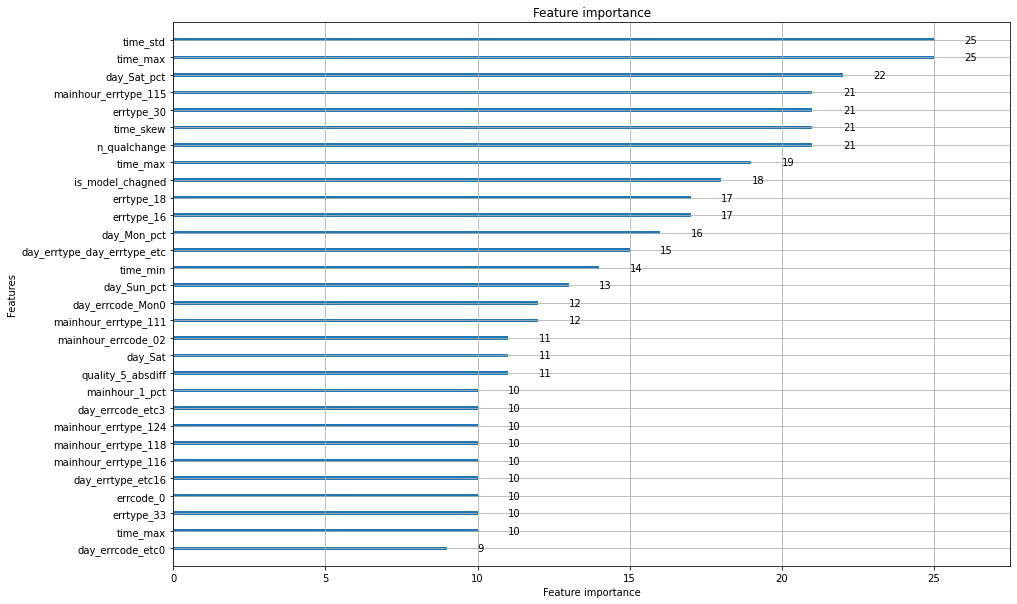

In [6]:
%%time
lgb_model = lgb.LGBMClassifier( n_estimators=100,
                               bagging_fraction = 0.9,
                               feature_fraction = 0.2,
                               num_leaves=16,
                               n_jobs = -1,
                               random_state=5)
result = cross_val_score(cv=5, estimator=lgb_model, X=train[X].values, y=train[y].values, scoring='roc_auc')
print(np.mean(result))

X_train, X_val, y_train, y_val= train_test_split(train[X], train[y], test_size=0.33, random_state=42)
lgb_model.fit(X_train, y_train)
pred = lgb_model.predict_proba(X_val)[:,1]
lgb.plot_importance(lgb_model, max_num_features=30, figsize=(15,10))
pd.crosstab(np.where(y_val>1, 1, y_val), np.where(pred>0.5, 1, 0))

In [7]:
%%time
xgb_model = xgb.XGBClassifier(colsample_bytree=0.7,
                          learning_rate=0.05, 
                          max_depth=4, 
                          n_estimators=300,
                          subsample=0.9,
                          random_state =7, 
                          nthread = -1)
result = cross_val_score(cv=5, estimator=xgb_model, X=train[X].values, y=train[y].values, scoring='roc_auc')
print(np.mean(result))
xgb_model.fit(train[X], train[y])
xgb.plot_importance(xgb_model, max_num_features=30)

0.83180795


ValueError: feature_names must be unique

In [8]:
gb_model = GradientBoostingClassifier(n_estimators=400, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=30, min_samples_split=10, 
                                   loss='deviance', random_state =5)
result = cross_val_score(cv=5, estimator=gb_model, X=train[X].values, y=train[y].values, scoring='roc_auc')
print(np.mean(result))

0.8323080999999999


rf_model = RandomForestClassifier(n_estimators=1000)
result = cross_val_score(cv=5, estimator=rf_model, X=train[X].values, y=train[y].values, scoring='roc_auc')
print(np.mean(result))

class Meta_Regressor(BaseEstimator):
    def __init__(self, base_models, meta_models):
        self.base_models = base_models # self.A = B 에서 A와 B가 이름이 같아야한다.. 뭐지 
        self.meta_models = meta_models
        
    def fit(self, X, y):
        self.base_models_ = [[] for _ in self.base_models]
        self.meta_models_ = clone(self.meta_models)
        
        Kf = KFold(n_splits=5, shuffle=True, random_state=5)
        out_fold_pred = np.zeros((len(X), len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_idx, val_idx in Kf.split(X):
                model = clone(self.base_models[i])
                model.fit(X[train_idx], y[train_idx])
                pred = model.predict_proba(X[val_idx])[:,1]
                out_fold_pred[val_idx, i] = pred
                self.base_models_[i].append(model)
                
        self.meta_models_.fit(X=out_fold_pred, y=y)
                  
    def predict_proba(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict_proba(X)[:,1] for model in sub_models]).mean(axis=1)
        for sub_models in self.base_models_])
        
        scores = self.meta_models_.predict_proba(meta_features)
        return scores


class Weighted_Ensemble(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
        
    def fit(self, X, y):
        self.models_ = [clone(model) for model in self.models]
        for model in self.models_:
            model.fit(X, y)
            
    def predict(self, x):
        results = np.zeros(len(x))
        scores = [model.predict_proba(x)[:,1] for model in self.models]
        for i, model in enumerate(scores):
            results += scores[i] * self.weights[i]
        return results
#         return np.concatenate([np.zeors(len(x)), scores], axis=1)
    
model = Weighted_Ensemble(models = [lgb_model, model_xgb, GBoost, rf, meta_model], weights=[0.2, 0.2, 0.2, 0.2, 0.2] )
result = cross_val_score(cv=5, estimator=model, X=train[X].values, y=train[y].values, scoring='roc_auc')
print(np.mean(result))

# Test

In [9]:
lgb_model.fit(train[X].values, train[y].values)
xgb_model.fit(train[X].values, train[y].values)
gb_model.fit(train[X].values, train[y].values)
# rf_model.fit(train[X].values, train[y].values)

del train_qual

In [10]:
test_err = pd.read_csv("/kaggle/input/dacon-lg/test_err_data.csv")
test_qual = pd.read_csv("/kaggle/input/dacon-lg/test_quality_data.csv")
sample_submission = pd.read_csv("/kaggle/input/dacon-lg/sample_submission.csv")
if is_trainn:
    test_err = test_err[:10000]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
test = preprcss(test_err, test_qual, is_train=False)
print(X[~X.isin(test.columns)])
test[X[~X.isin(test.columns)]] = 0

pred_lgb = lgb_model.predict_proba(test[X].values)[:,1]
pred_xgb = xgb_model.predict_proba(test[X].values)[:,1]
pred_gb = gb_model.predict_proba(test[X].values)[:,1]
# pred_rf = rf_model.predict_proba(test[X].values)[:,1]


100%|██████████| 16532648/16532648 [00:56<00:00, 291674.19it/s]


Index([], dtype='object')


In [12]:
pred = pred_lgb*0.34 + pred_xgb*0.33 + pred_gb*0.33
test['pred_lgb'] = pred_lgb
test['pred_xgb'] = pred_xgb
test['pred_gb'] = pred_gb
test['problem'] = pred
sample_submission = sample_submission[['user_id']].merge(test[['user_id', 'problem', 'pred_lgb', 'pred_xgb', 'pred_gb']], how='left', on='user_id')
sample_submission.loc[sample_submission['user_id']==43262, 'problem'] = 0.5
sample_submission.loc[sample_submission['user_id']==43262, 'pred_lgb'] = 0.5
sample_submission.loc[sample_submission['user_id']==43262, 'pred_xgb'] = 0.5
sample_submission.loc[sample_submission['user_id']==43262, 'pred_gb'] = 0.5
sample_submission.to_csv("submission.csv", index=False)
sample_submission

,user_id,problem,pred_lgb,pred_xgb,pred_gb
0,30000,0.948152,0.941667,0.953491,0.949494
1,30001,0.279620,0.275750,0.289766,0.273462
2,30002,0.347275,0.317199,0.328947,0.396590
3,30003,0.838679,0.821974,0.847519,0.847049
4,30004,0.940037,0.954747,0.904753,0.960165
...,...,...,...,...,...
14994,44994,0.226866,0.239987,0.203619,0.236596
14995,44995,0.216066,0.180670,0.256136,0.212465
14996,44996,0.771944,0.788072,0.794473,0.732799
14997,44997,0.854704,0.910081,0.837486,0.814868
